<a href="https://colab.research.google.com/github/climate-and-health-datasci-Unicamp/ldl-cholesterol-climate-analysis/blob/master/models/Future_ColdWaves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author:**
* [Daniela Souza de Oliveira](https://github.com/Danielaso)

*created in jun/2020*

##**Computing Cold Waves using Forecasted Climate Data**

INPUT:

[Forecasted_IAC.csv](https://drive.google.com/file/d/1Ls-gTTFdljOquzbgYuspsB6jF2Jrxnx5/view?usp=sharing), with Maximum and Minimum Temperatures predictions for IAC weather station from 2019 to 2028

[HW_IAC.csv](https://drive.google.com/file/d/1n96uNSGPlEO5RYEyaLqYMpevPpymK4KZ/view?usp=sharing), historical data from IAC

OUTPUT:

ForecastedCW_IAC.csv, with computed cold waves (boolean CW colum - 1 for days that are part of a cold wave and 0 otherwise)



In [5]:
#importing libraries

import pandas as pd
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [6]:
#-------------------------------------------------------------------#
#                    Personal libraries                             #
#-------------------------------------------------------------------#
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#id obtained from shareable link in gdrive file
googl = drive.CreateFile({'id':'1QO82ZxnuuhEoM3dDgG2O8NCIgj862H3N'})
googl.GetContentFile('Extreme_Waves.py')

In [7]:
#importing module with functions to compute Cold Waves

import Extreme_Waves as EW

### **Loading data**



1.   Forecasted_IAC.csv, containing temperature predictions data estimated with SARIMA -> dfIAC_pred
2.   HW_IAC.csv, historical data from IAC -> histIAC



In [8]:
## NEW
#loading dfIAC_pred (forecasted data)
googl = drive.CreateFile({'id':'1Ls-gTTFdljOquzbgYuspsB6jF2Jrxnx5'})
googl.GetContentFile('Forecasted_IAC.csv')
dfIAC_pred = pd.read_csv('/content/Forecasted_IAC.csv') #dataframe with forecasted data

#loading historical data to obtain climatological normal
googl = drive.CreateFile({'id':'1n96uNSGPlEO5RYEyaLqYMpevPpymK4KZ'})
googl.GetContentFile('HW_IAC.csv')
histIAC = pd.read_csv('/content/HW_IAC.csv') #climatic normal dataframe


#### Using historical data to extract climatological normal 1961 - 1990

In [9]:
#removing unnecessary columns from historical data

del histIAC['Unnamed: 0']
del histIAC['N_RAIN_TOT']
del histIAC['above_pct']
del histIAC['HW']

#converting DATE column to datetime data type

histIAC['DATE'] = pd.to_datetime(histIAC['DATE'])

In [10]:
#defining climatic normal period 1961 - 1990

climatic_normal = histIAC[(histIAC.DATE.dt.year>1960)&(histIAC.DATE.dt.year<=1990)]
climatic_normal

,DAY365,DATE,YEAR,N_AIRTMP_MAX,N_AIRTMP_MIN
1825,1,1961-01-01,1961,27.9,19.0
1826,2,1961-01-02,1961,26.0,19.1
1827,3,1961-01-03,1961,31.4,19.0
1828,4,1961-01-04,1961,27.9,20.0
1829,5,1961-01-05,1961,30.7,18.7
...,...,...,...,...,...
12770,361,1990-12-27,1990,29.8,18.4
12771,362,1990-12-28,1990,31.2,17.0
12772,363,1990-12-29,1990,24.6,18.2
12773,364,1990-12-30,1990,26.0,11.2


In [11]:
climatic_normal = climatic_normal.reset_index()
del climatic_normal['index']
climatic_normal

,DAY365,DATE,YEAR,N_AIRTMP_MAX,N_AIRTMP_MIN
0,1,1961-01-01,1961,27.9,19.0
1,2,1961-01-02,1961,26.0,19.1
2,3,1961-01-03,1961,31.4,19.0
3,4,1961-01-04,1961,27.9,20.0
4,5,1961-01-05,1961,30.7,18.7
...,...,...,...,...,...
10945,361,1990-12-27,1990,29.8,18.4
10946,362,1990-12-28,1990,31.2,17.0
10947,363,1990-12-29,1990,24.6,18.2
10948,364,1990-12-30,1990,26.0,11.2


#### Predicted temperature data

In [12]:
# predicted temperature data
del dfIAC_pred ['Unnamed: 0']
dfIAC_pred['DATE'] = pd.to_datetime(dfIAC_pred['DATE'])
dfIAC_pred = dfIAC_pred.round(2)

In [13]:
dfIAC_pred

,DATE,Forecasted_Tmax,Forecasted_Tmin
0,2019-01-01,26.13,19.29
1,2019-01-02,30.75,19.05
2,2019-01-03,26.06,18.60
3,2019-01-04,28.15,18.84
4,2019-01-05,26.66,18.63
...,...,...,...
3648,2028-12-27,34.06,21.84
3649,2028-12-28,28.93,20.34
3650,2028-12-29,26.54,16.48
3651,2028-12-30,29.86,18.74


###**Using function to check the next Cold Wave occurrences 2019-2028**

---



In [14]:
help(EW.check_ColdWave)

Help on function check_ColdWave in module Extreme_Waves:

check_ColdWave(climatic_normal, pct_columnMAX, pct_columnMIN, cn_columnDay365, database, db_columnMAX, db_columnMIN, db_columnDay365, db_complete, percentile_value, window_size)
    #-------------------------------------------------------------------------------
    ## Checks for Cold Waves on the database according to the Climatic Normal
    ##
    ## Checks for Cold Waves on the database according to the Climatic Normal This
    ## function uses Geirinhas et al. method It obtains first a dataframe with the
    ## percentiles computed from the Climatic Normal according to the defined window
    ## size Then compares it with the database, to check if the maximum and minimum
    ## temperatures are below the corresponding percentile If the temperatures are
    ## above the threshold, the column 'below_pct' receives 1 This column is then
    ## used to identify if there are 3 or more consecutive extremely cold days (Cold
    ## Wa

In [15]:
ForecastedCW_IAC, df_pct = EW.check_ColdWave(climatic_normal,'N_AIRTMP_MAX','N_AIRTMP_MIN',1,dfIAC_pred,'Forecasted_Tmax','Forecasted_Tmin',0,0,0.1,15)

/content/Extreme_Waves.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['below_pct'] = np.where(((df_year[db_columnMAX] <= df_pct['CTX10pct']) & (df_year[db_columnMIN] <= df_pct['CTN10pct'])), 1, 0) #checks if the value in db_column is equal or less than the corresponding percentile
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
#Percentiles dataframe obtained from climatological normal data

df_pct

,CTX10pct,CTN10pct
DAY365,,
1,25.00,16.20
2,25.17,16.40
3,25.20,16.40
4,25.20,16.35
5,25.20,16.40
...,...,...
361,24.60,16.00
362,24.60,16.00
363,24.60,16.00


In [17]:
# dataframe containg forecasted data and information about cold days ('below_pct') and cold waves ('CW')

ForecastedCW_IAC

,DAY365,DATE,Forecasted_Tmax,Forecasted_Tmin,below_pct,CW
0,1,2019-01-01,26.13,19.29,0,0
1,2,2019-01-02,30.75,19.05,0,0
2,3,2019-01-03,26.06,18.60,0,0
3,4,2019-01-04,28.15,18.84,0,0
4,5,2019-01-05,26.66,18.63,0,0
...,...,...,...,...,...,...
3645,361,2028-12-27,34.06,21.84,0,0
3646,362,2028-12-28,28.93,20.34,0,0
3647,363,2028-12-29,26.54,16.48,0,0
3648,364,2028-12-30,29.86,18.74,0,0


In [18]:
ForecastedCW_IAC[ForecastedCW_IAC.CW==1]

,DAY365,DATE,Forecasted_Tmax,Forecasted_Tmin,below_pct,CW
3386,102,2028-04-12,24.07,12.04,1,1
3387,103,2028-04-13,22.86,14.15,1,1
3388,104,2028-04-14,23.66,12.00,1,1


In [19]:
#saving file
#df_IAC_forecast.to_csv('ForecastedCW_IAC.csv')
#!cp Forecasted_IAC.csv '/content/drive/Shared drives/'

## **Using Climate Models to predict future Cold Waves**

- Projections from ETA model for IAC coordinates 
https://projeta.cptec.inpe.br/#/dashboard

INPUT:

IAC_eta05km_TmaxD2.csv, IAC_eta05km_TminD2.csv, maximum and minimum temperatures predictions downloaded from Projeta

HW_IAC.csv, historical data from IAC

OUTPUT: Coldwave metrics plots, comparing data since 2008 until 2050


### **Data from ETA climate model**

Reading data extracted from https://projeta.cptec.inpe.br/

2 files were obtained: 

1.   IAC_eta05km_TmaxD2 (with maximum temperatures) -> df_IAC_tmax5

2.   IAC_eta05km_TminD2 (with minimum temperatures) -> df_IAC_tmin5

Model: ETA 5km RCP4.5, sudesteD2-BR, HADGEM2-ES

Coordinates: Latitude -22.85, Longitude -47.05 (approx. IAC weather station coordinates)

Period: 2019 - 2050









#### Loading files from the ETA model
---



In [20]:
# loading files from the model
googl = drive.CreateFile({'id':'139Qz4dQkrwFJdB5k14xWQMzOvy0nzy04'})
googl.GetContentFile('IAC_eta05km_TmaxD2.csv')
df_IAC_tmax5 = pd.read_csv('/content/IAC_eta05km_TmaxD2.csv',sep=";",usecols=['Data','MXTP']) # Maximum temperature dataframe

googl = drive.CreateFile({'id':'1YgTXqMnyRZA60yEgsYpZhJsaSaX0DdzK'})
googl.GetContentFile('IAC_eta05km_TminD2.csv')
df_IAC_tmin5 = pd.read_csv('/content/IAC_eta05km_TminD2.csv',sep=";",usecols=['Data','MNTP']) # Maximum temperature dataframe

In [21]:
# adjusting dates column

df_IAC_tmax5['Data']=pd.to_datetime(df_IAC_tmax5.Data,errors='coerce')
df_IAC_tmin5['Data']=pd.to_datetime(df_IAC_tmin5.Data,errors='coerce')

In [22]:
# removing columns with invalid dates

df_IAC_tmax5 = df_IAC_tmax5.dropna()
df_IAC_tmin5 = df_IAC_tmin5.dropna()

In [23]:
# sorting dataframe by dates

df_IAC_tmax5 = df_IAC_tmax5.sort_values(by='Data')
df_IAC_tmin5 = df_IAC_tmin5.sort_values(by='Data')

In [24]:
df_IAC_tmax5 = df_IAC_tmax5.reset_index()
del df_IAC_tmax5['index']
df_IAC_tmax5

,Data,MXTP
0,2018-01-01,35.772217
1,2018-01-02,36.723114
2,2018-01-03,30.314667
3,2018-01-04,31.037476
4,2018-01-05,32.765533
...,...,...
11817,2050-12-26,33.900055
11818,2050-12-27,33.223175
11819,2050-12-28,31.935028
11820,2050-12-29,30.118500


In [25]:
df_IAC_tmin5 = df_IAC_tmin5.reset_index()
del df_IAC_tmin5['index']
df_IAC_tmin5

,Data,MNTP
0,2018-01-01,22.111847
1,2018-01-02,22.952545
2,2018-01-03,22.376740
3,2018-01-04,18.651917
4,2018-01-05,18.682037
...,...,...
11817,2050-12-26,23.019989
11818,2050-12-27,22.144348
11819,2050-12-28,19.201996
11820,2050-12-29,20.113892


#### Merging Tmax and Tmin dataframes


In [26]:
df_IAC_pred5 = pd.merge(df_IAC_tmax5, df_IAC_tmin5,on='Data')

In [27]:
df_IAC_pred5

,Data,MXTP,MNTP
0,2018-01-01,35.772217,22.111847
1,2018-01-02,36.723114,22.952545
2,2018-01-03,30.314667,22.376740
3,2018-01-04,31.037476,18.651917
4,2018-01-05,32.765533,18.682037
...,...,...,...
11817,2050-12-26,33.900055,23.019989
11818,2050-12-27,33.223175,22.144348
11819,2050-12-28,31.935028,19.201996
11820,2050-12-29,30.118500,20.113892


In [28]:
#renaming columns
df_IAC_pred5 = df_IAC_pred5.rename(columns={'Data':'DATE','MXTP':'N_AIRTMP_MAX','MNTP':'N_AIRTMP_MIN'})

In [29]:
df_IAC_pred5 = df_IAC_pred5.round(2)
df_IAC_pred5

,DATE,N_AIRTMP_MAX,N_AIRTMP_MIN
0,2018-01-01,35.77,22.11
1,2018-01-02,36.72,22.95
2,2018-01-03,30.31,22.38
3,2018-01-04,31.04,18.65
4,2018-01-05,32.77,18.68
...,...,...,...
11817,2050-12-26,33.90,23.02
11818,2050-12-27,33.22,22.14
11819,2050-12-28,31.94,19.20
11820,2050-12-29,30.12,20.11


###**Using function to check the next Cold Wave occurrences 2019 - 2050**
---

In [30]:
# Computing Cold Waves on predicted data according to the climatic normal 1961-1990 (previously loaded)

PredCW_IAC,df_pct = EW.check_ColdWave(climatic_normal,'N_AIRTMP_MAX','N_AIRTMP_MIN',1,df_IAC_pred5,'N_AIRTMP_MAX','N_AIRTMP_MIN',0,0,0.1,15)

/content/Extreme_Waves.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['below_pct'] = np.where(((df_year[db_columnMAX] <= df_pct['CTX10pct']) & (df_year[db_columnMIN] <= df_pct['CTN10pct'])), 1, 0) #checks if the value in db_column is equal or less than the corresponding percentile
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [31]:
PredCW_IAC

,DAY365,DATE,N_AIRTMP_MAX,N_AIRTMP_MIN,below_pct,CW
0,1,2018-01-01,35.77,22.11,0,0
1,2,2018-01-02,36.72,22.95,0,0
2,3,2018-01-03,30.31,22.38,0,0
3,4,2018-01-04,31.04,18.65,0,0
4,5,2018-01-05,32.77,18.68,0,0
...,...,...,...,...,...,...
12040,361,2050-12-27,33.22,22.14,0,0
12041,362,2050-12-28,31.94,19.20,0,0
12042,363,2050-12-29,30.12,20.11,0,0
12043,364,2050-12-30,32.36,20.21,0,0


In [32]:
# Checking days with cold waves

PredCW_IAC[PredCW_IAC['CW']==1]

,DAY365,DATE,N_AIRTMP_MAX,N_AIRTMP_MIN,below_pct,CW
4354,340,2029-12-06,18.06,11.47,1,1
4355,341,2029-12-07,24.18,9.28,1,1
4356,342,2029-12-08,24.59,13.34,1,1
5511,37,2033-02-06,21.71,10.91,1,1
5512,38,2033-02-07,25.61,13.19,1,1
5513,39,2033-02-08,22.61,16.78,1,1
5539,65,2033-03-06,23.32,12.17,1,1
5540,66,2033-03-07,23.49,16.73,1,1
5541,67,2033-03-08,24.14,15.77,1,1
5876,37,2034-02-06,26.22,16.40,1,1


###**Using function to check the past Cold Wave occurrences 2008-2018**


In [33]:
# extracting data from IAC for 2008 - 2018 period

dfIAC_past = histIAC[(histIAC.DATE.dt.year>=2008)&(histIAC.DATE.dt.year<=2018)]

In [34]:
dfIAC_past.head()

,DAY365,DATE,YEAR,N_AIRTMP_MAX,N_AIRTMP_MIN
18980,1,2008-01-01,2008,34.6,22.4
18981,2,2008-01-02,2008,31.2,21.0
18982,3,2008-01-03,2008,33.0,19.6
18983,4,2008-01-04,2008,31.0,18.2
18984,5,2008-01-05,2008,29.4,20.0


In [35]:
PastCW_IAC, df_pct = EW.check_ColdWave(climatic_normal,'N_AIRTMP_MAX','N_AIRTMP_MIN',1,dfIAC_past,'N_AIRTMP_MAX','N_AIRTMP_MIN',0,0,0.1,15)

/content/Extreme_Waves.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['below_pct'] = np.where(((df_year[db_columnMAX] <= df_pct['CTX10pct']) & (df_year[db_columnMIN] <= df_pct['CTN10pct'])), 1, 0) #checks if the value in db_column is equal or less than the corresponding percentile
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [36]:
PastCW_IAC

,DAY365,DATE,YEAR,N_AIRTMP_MAX,N_AIRTMP_MIN,below_pct,CW
0,1,2008-01-01,2008.0,34.6,22.4,0,0
1,2,2008-01-02,2008.0,31.2,21.0,0,0
2,3,2008-01-03,2008.0,33.0,19.6,0,0
3,4,2008-01-04,2008.0,31.0,18.2,0,0
4,5,2008-01-05,2008.0,29.4,20.0,0,0
...,...,...,...,...,...,...,...
4010,361,2018-12-27,2018.0,28.8,19.0,0,0
4011,362,2018-12-28,2018.0,31.2,18.6,0,0
4012,363,2018-12-29,2018.0,31.7,18.7,0,0
4013,364,2018-12-30,2018.0,32.1,19.8,0,0


In [37]:
PastCW_IAC[PastCW_IAC['CW']==1]

,DAY365,DATE,YEAR,N_AIRTMP_MAX,N_AIRTMP_MIN,below_pct,CW
754,25,2010-01-25,2010.0,24.0,14.9,1,1
755,26,2010-01-26,2010.0,21.8,14.9,1,1
756,27,2010-01-27,2010.0,25.1,15.0,1,1
826,97,2010-04-07,2010.0,18.2,12.0,1,1
827,98,2010-04-08,2010.0,21.7,11.5,1,1
828,99,2010-04-09,2010.0,22.3,12.0,1,1
829,100,2010-04-10,2010.0,22.5,11.3,1,1
830,101,2010-04-11,2010.0,24.1,13.2,1,1
1113,19,2011-01-19,2011.0,25.3,16.8,1,1
1114,20,2011-01-20,2011.0,25.3,16.9,1,1


### **Using function to extract Coldwave metrics  - Past and Future**



1.   CWN - number of coldwaves per year
2.   CWD - longest duration of coldwaves per year
3.   CWF - sum of coldwave days






#####**2019 - 2050 Coldwave Metrics**



In [38]:
# Extracting CW metrics from 2019 - 2050

PredCW_IAC_metrics=EW.wave_metrics(PredCW_IAC,'CW')

In [39]:
PredCW_IAC_metrics

,CWN,CWD,CWF
YEAR,,,
2018,0.0,0.0,0.0
2019,0.0,0.0,0.0
2020,0.0,0.0,0.0
2021,0.0,0.0,0.0
2022,0.0,0.0,0.0
2023,0.0,0.0,0.0
2024,0.0,0.0,0.0
2025,0.0,0.0,0.0
2026,0.0,0.0,0.0


In [40]:
PredCW_IAC_metrics.describe()

,CWN,CWD,CWF
count,33.000000,33.000000,33.000000
mean,0.363636,0.727273,1.090909
std,0.742386,1.305582,2.227157
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,3.000000,3.000000,9.000000


##### **2008 - 2018 Coldwave metrics**


In [41]:
# Extracting CW metrics 2008 - 2018

PastCW_IAC_metrics=EW.wave_metrics(PastCW_IAC,'CW')
PastCW_IAC_metrics

,CWN,CWD,CWF
YEAR,,,
2008,0.0,0.0,0.0
2009,0.0,0.0,0.0
2010,2.0,5.0,8.0
2011,2.0,4.0,7.0
2012,3.0,3.0,9.0
2013,1.0,3.0,3.0
2014,0.0,0.0,0.0
2015,0.0,0.0,0.0
2016,1.0,3.0,3.0


In [42]:
PastCW_IAC_metrics.describe()

,CWN,CWD,CWF
count,11.000000,11.000000,11.000000
mean,0.818182,1.636364,2.727273
std,1.078720,1.963300,3.608072
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.500000,3.000000,5.000000
max,3.000000,5.000000,9.000000


##### **Joining metrics dataframes Past and Future**



1.   2008 - 2018 (IAC data)
2.   2019 - 2050 (ETA model)




In [43]:
CWmetrics_2008_2050 = pd.concat([PastCW_IAC_metrics,PredCW_IAC_metrics])

In [44]:
CWmetrics_2008_2050

,CWN,CWD,CWF
YEAR,,,
2008,0.0,0.0,0.0
2009,0.0,0.0,0.0
2010,2.0,5.0,8.0
2011,2.0,4.0,7.0
2012,3.0,3.0,9.0
2013,1.0,3.0,3.0
2014,0.0,0.0,0.0
2015,0.0,0.0,0.0
2016,1.0,3.0,3.0


In [45]:
CWmetrics_2008_2050.describe()

,CWN,CWD,CWF
count,44.000000,44.000000,44.000000
mean,0.477273,0.954545,1.500000
std,0.848765,1.524292,2.689342
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,3.000000,3.000000
max,3.000000,5.000000,9.000000


#### **Plotting Cold Wave Metrics**

Cold waves parameters: past and future 2008 - 2050

1.   CWN - number of cold waves per year
2.   CWD - longest duration of cold waves per year
3.   CWF - sum of days under cold waves


In [46]:
# function to generate a plot for a metric

def plot_CW_Metric(df_metrics,metric,title):
    fig, axes = plt.subplots(figsize=(8,8))

    fig.suptitle(title,fontsize=15)
   
    axes.bar(df_metrics.index, df_metrics[metric])
    #axes.bar(df_metrics.index, df_metrics[metric],color='orange')
    #axes.bar(df_metrics.index, df_metrics[metric],color='green')
    
    axes.xaxis.set_ticks(np.arange(2008, 2050, 4))
    axes.tick_params(axis='both', which='major', labelsize=12)
    axes.grid()
    
    axes.set_ylim(0,5)
    #axes.set_title(title,fontsize=25)
    
    axes.set_ylabel('Number of Days',fontsize=12)
    #axes.set_ylabel('Number of Coldwaves',fontsize=20)

    return


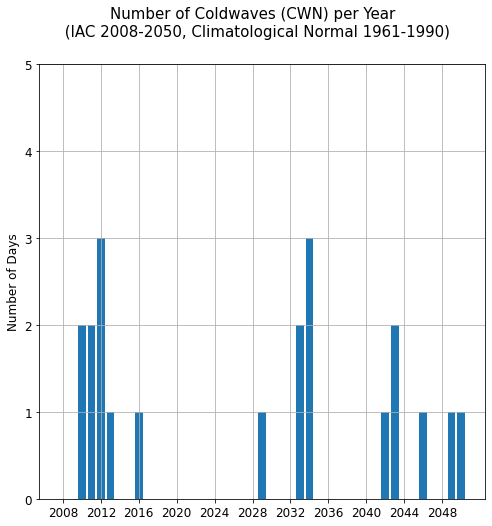

In [54]:
# generating CWN plot

plot_CW_Metric(CWmetrics_2008_2050,'CWN','Number of Coldwaves (CWN) per Year \n (IAC 2008-2050, Climatological Normal 1961-1990)')
#plt.savefig('/content/drive/Shared drives/Clima&Saúde/Pesquisadores/Oliveira_Daniela/CWN.png', bbox_inches = 'tight')


(0.0, 6.0)

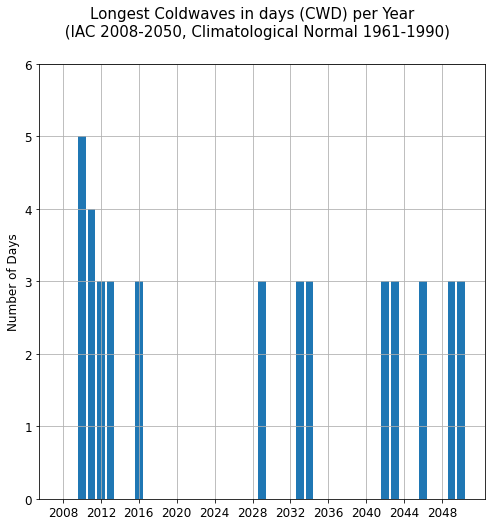

In [48]:
# generating CWD plot

plot_CW_Metric(CWmetrics_2008_2050,'CWD','Longest Coldwaves in days (CWD) per Year \n (IAC 2008-2050, Climatological Normal 1961-1990)')
plt.ylim(0,6)
#plt.savefig('/content/drive/Shared drives/Clima&Saúde/Pesquisadores/Oliveira_Daniela/CWD.png', bbox_inches = 'tight')

(0.0, 10.0)

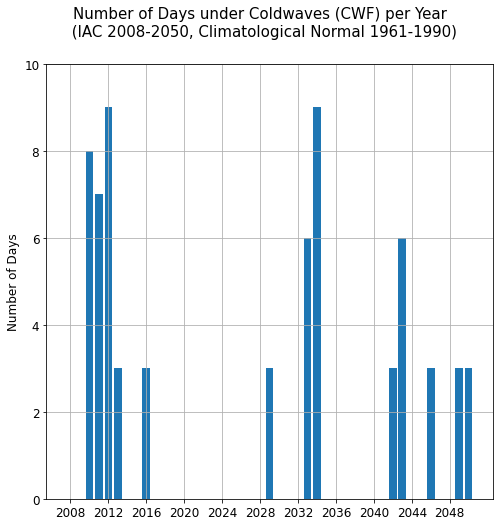

In [49]:
# generating CWF plot

plot_CW_Metric(CWmetrics_2008_2050,'CWF','Number of Days under Coldwaves (CWF) per Year \n (IAC 2008-2050, Climatological Normal 1961-1990)')
plt.ylim(0,10)
#plt.savefig('/content/drive/Shared drives/Clima&Saúde/Pesquisadores/Oliveira_Daniela/CWF.png', bbox_inches = 'tight')